In [1]:
from pathlib import Path
import sys
sys.path.append('../bitome-kb/')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import seaborn as sns

from Bio.Align import AlignInfo, MultipleSeqAlignment
import Bio.motifs as motifs
from Bio.SeqFeature import FeatureLocation
from Bio.SeqRecord import SeqRecord
from matplotlib.patches import Rectangle

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight
from bitome.core import Bitome
from math import log,exp,inf
bitome = Bitome.init_from_file('../bitome-kb/bitome.pkl')

In [2]:
import ast
im_info = pd.read_csv('data/precise2_im_info_new.csv')
IM_genes = {}
for i in range(len(im_info['im_name'])):
    IM_genes[im_info['im_name'][i]] = ast.literal_eval( im_info['genes'][i] )
IM_genes.keys()

dict_keys(['CysB-1', 'HprR+CusR', 'PhoB-1', 'Fnr-1', 'TdcAR', 'Fimbriae', 'PurR-2', 'Fnr+NarL', 'GalRS', 'BtsR', 'PyrR', 'PlaR', 'RpoN+FhlA', 'RhaS', 'NanR', 'FadR', 'NrdR', 'GlcC', 'BaeR+CpxR', 'NikR', 'Isoleucine', 'RpoN+PspF', 'OxyR', 'TrpR', 'CsqR', 'LldR', 'Thiamine-1', 'PuuR', 'YcjW', 'PdhR+OmpR', 'NsrR', 'GntR', 'Fnr+NarLP', 'RcsAB', 'MalT', 'TyrR', 'Molybdopterin', 'Fnr-2', 'AtoC', 'Leucine', 'SoxS', 'Translation', 'RcnR', 'Lrp', 'Nac', 'KdpE', 'PhoB-2', 'RbsR', 'CysB-2', 'FlhDC-1', 'GatR', 'ArgR', 'GadX', 'RpoN+NtrC-1', 'XylR', 'ArcA', 'BirA', 'EvgA', 'BluR', 'LsrR', 'Zur', 'RpoE', 'Fur-1', 'PurR-1', 'ArgP', 'AllR', 'FucR', 'Fur-2', 'Mlc', 'CecR', 'Fnr+IHF+gcvB', 'YgbI', 'LexA', 'Cra', 'GlpR', 'RpoN+NtrC-2', 'PaaX', 'Oligopeptide', 'CdaR', 'RpoN+PrpR+Cra', 'FliA', 'CpxR', 'Histidine', 'RpoH', 'GadE+FliZ', 'GcvA', 'YdeO+H-NS', 'NagC', 'GutM+SrlR', 'MetJ', 'RpoS', 'CysB-3', 'FlhDC-2', 'RutR', 'PhoP', 'RyhB', 'BasR', 'NarL', 'RpoS+ArgR+RpoN', 'Crp-related-2'])

In [3]:
tf_list =['AraC', 'ArcA', 'ArgP', 'ArgR', 'BaeR', 'BasR', 'CysB', 'CpxR', 
          'Cra', 'CRP', 'Mlc', 'MqsA', 'EvgA', 'ExuR', 'FadR', 'IclR', 'IscR', 
          'IHF', 'FhlA', 'FlhDC', 'FNR', 'Fur', 'GadE', 'GadW', 'GadX', 'GalR', 'GalS', 
          'GcvA', 'GlpR', 'GlrR', 'GntR', 'TyrR', 'LexA', 'LeuO', 'Lrp', 'MalT', 'MetJ', 'Nac', 
          'NagC', 'NanR', 'NarL', 'NarP', 'NrdR', 'NsrR', 'NtrC', 'OmpR', 'OxyR', 'PdhR', 'PhoB', 'PhoP',
          'PurR', 'PuuR', 'RcsAB', 'RhaS', 'RutR', 'SoxS', 'TrpR', 'XylR', 'YdeO']

regulon_genes={}
for TF in bitome.transcription_factors:
    if TF.name in tf_list:
        regulon_genes[TF.name] = []   
        for r in TF.regulons:
                for p in list(r.regulated_promoters.values())[0]:
                    if p.transcription_unit != None and len(p.transcription_unit.genes)>0:
                        for g in p.transcription_unit.genes:
                            regulon_genes[TF.name].append( g.locus_tag)

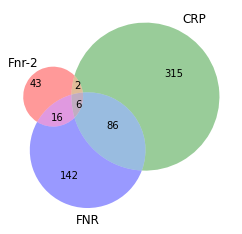

In [10]:
from matplotlib_venn import venn3
venn3([set(IM_genes['Fnr-2']),set(regulon_genes['CRP']),set(regulon_genes['FNR'])],
      set_labels = ('Fnr-2','CRP','FNR'))

In [5]:
def get_tfs_IM( b_list ):
    result = []
    for b in b_list:
        for r in list(regulon_genes.keys()):
            if b in list(regulon_genes[r]):
                result.append( r )  
    return result


b_g = {}
for g in bitome.genes:
    b_g[g.locus_tag] = g.name

Text(0.5, 0, 'TFs')

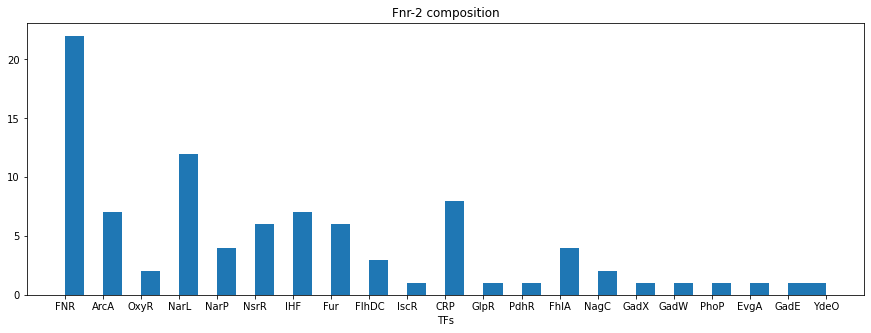

In [6]:
im_name = 'Fnr-2'
x = get_tfs_IM( list(IM_genes[im_name]) )
plt.figure(figsize=(15,5))
plt.hist(x,bins = 40)
plt.title(im_name+' composition')
plt.xlabel('TFs')

Text(0.5, 0, 'TFs')

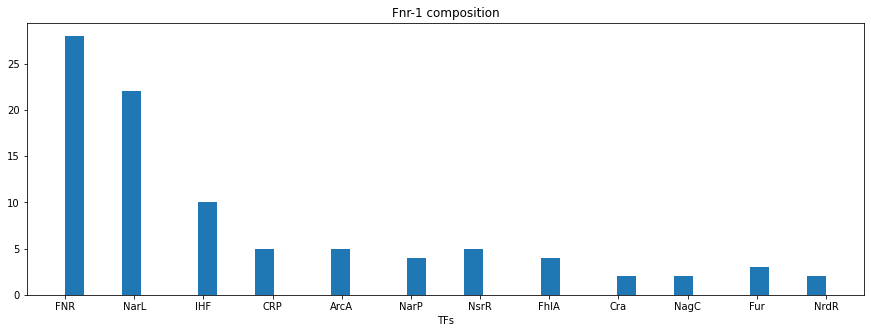

In [7]:
im_name = 'Fnr-1'
x = get_tfs_IM( list(IM_genes[im_name]) )
plt.figure(figsize=(15,5))
plt.hist(x,bins = 40)
plt.title(im_name+' composition')
plt.xlabel('TFs')

## Flexibly Construct X Matrix
### For Multiple TSS at Same Gene

In [4]:
N_UP = 50
N_DOWN = 10
one_hot = []
for g in bitome.genes:
    if len(g.transcription_units) < 1:
        continue
    data={}
    data['ID'] = g.locus_tag
    data['gene'] = g.name
    result =  bitome.tss_consensus_from_gene(g,N_UP,N_DOWN)
    data.update( dict(result) )
    one_hot.append(data)
        
raw_pd = pd.DataFrame(one_hot)
raw_pd = raw_pd.dropna()
raw_pd = raw_pd.reset_index()
raw_pd = raw_pd.drop(columns=['index'])
raw_pd.head()

,ID,gene,-50_A,-49_A,-48_A,-47_A,-46_A,-45_A,-44_A,-43_A,...,1_G,2_G,3_G,4_G,5_G,6_G,7_G,8_G,9_G,10_G
0,b0008,talB,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,0.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000
1,b0014,dnaK,0.666667,0.333333,0.333333,0.333333,0.0,0.666667,0.333333,0.666667,...,0.0,0.0,0.0,0.333333,0.333333,0.0,0.666667,0.333333,0.333333,0.666667
2,b0015,dnaJ,0.666667,0.333333,0.333333,0.333333,0.0,0.666667,0.333333,0.666667,...,0.0,0.0,0.0,0.333333,0.333333,0.0,0.666667,0.333333,0.333333,0.666667
3,b0019,nhaA,1.000000,0.500000,0.500000,0.000000,0.5,1.000000,0.000000,0.500000,...,0.5,0.5,0.0,0.000000,0.000000,0.0,0.000000,0.500000,0.000000,0.500000
4,b0020,nhaR,1.000000,0.500000,0.500000,0.000000,0.5,1.000000,0.000000,0.500000,...,0.5,0.5,0.0,0.000000,0.000000,0.0,0.000000,0.500000,0.000000,0.500000


# t-SNE

In [5]:
X = raw_pd.iloc[:,2:].values
X = StandardScaler().fit_transform(X)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,perplexity = 0.05 )
X_tsne = tsne.fit_transform(X)

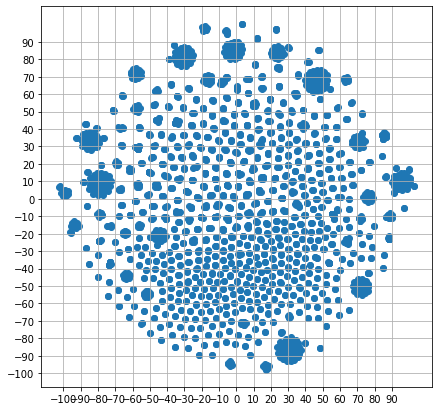

In [8]:
plt.figure(figsize=(7,7))
plt.scatter( X_tsne[:,0], X_tsne[:,1])
plt.xticks(np.arange(-100,100,10))
plt.yticks(np.arange(-100,100,10))
plt.grid()
plt.show()

In [22]:
tsne_clusters= {1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[],11:[]}
for i in range(len(X_tsne)):
    if X_tsne[i][0] >= -90 and X_tsne[i][0] <= -70 and X_tsne[i][1] >= 0 and X_tsne[i][1] <= 20:
        tsne_clusters[1].append( raw_pd['ID'][i] )
    elif X_tsne[i][0] >= -100 and X_tsne[i][0] <= -70 and X_tsne[i][1] >= 25 and X_tsne[i][1] <= 50:
        tsne_clusters[2].append( raw_pd['ID'][i] )
    elif X_tsne[i][0] >= -40 and X_tsne[i][0] <= -22 and X_tsne[i][1] >= 72 and X_tsne[i][1] <= 90:
        tsne_clusters[3].append( raw_pd['ID'][i] )
    elif X_tsne[i][0] >= -10 and X_tsne[i][0] <= 5 and X_tsne[i][1] >= 75 and X_tsne[i][1] <= 92:
        tsne_clusters[4].append( raw_pd['ID'][i] )
    elif X_tsne[i][0] >= 38 and X_tsne[i][0] <= 60 and X_tsne[i][1] >= 60 and X_tsne[i][1] <= 80:
        tsne_clusters[5].append( raw_pd['ID'][i] )
    elif X_tsne[i][0] >= 85 and X_tsne[i][1] >= 0 and X_tsne[i][1] <= 20:
        tsne_clusters[6].append( raw_pd['ID'][i] )
    elif X_tsne[i][0] >= 65 and X_tsne[i][0] <= 80 and X_tsne[i][1] >= -60 and X_tsne[i][1] <= -44:
        tsne_clusters[7].append( raw_pd['ID'][i] )
    elif X_tsne[i][0] >= 20 and X_tsne[i][0] <= 40 and X_tsne[i][1] >= -100 and X_tsne[i][1] <= -78:
        tsne_clusters[8].append( raw_pd['ID'][i] )
    elif X_tsne[i][0] >= -65  and X_tsne[i][0] <= -50 and X_tsne[i][1] >= 65  and X_tsne[i][1] <= 80 :
        tsne_clusters[9].append( raw_pd['ID'][i] )
    elif X_tsne[i][0] >= 18  and X_tsne[i][0] <= 30 and X_tsne[i][1] >= 77  and X_tsne[i][1] <= 90 :
        tsne_clusters[10].append( raw_pd['ID'][i] )
    elif X_tsne[i][0] >= 65  and X_tsne[i][0] <= 80 and X_tsne[i][1] >= 25  and X_tsne[i][1] <= 40 :
        tsne_clusters[11].append( raw_pd['ID'][i] )

In [23]:
import matplotlib.colors as colors
color_list = list(colors.CSS4_COLORS.keys())[10:120]

In [24]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc = 'right', ncol = 2,bbox_to_anchor=(1.5, 0.5))

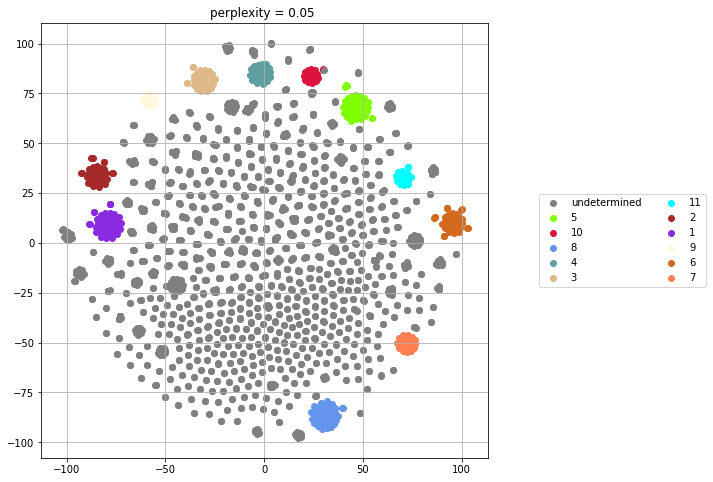

In [25]:
fig, ax = plt.subplots( figsize = (8,8))
for i in range(len(X_tsne)):
    color = 'gray'
    lab = 'undetermined'
    
    for j in range(len(tsne_clusters.keys())):
        if raw_pd['ID'][i] in list(tsne_clusters[ list(tsne_clusters.keys())[j] ]):
            color = color_list[j]
            lab = list(tsne_clusters.keys())[j]
            
    ax.scatter(X_tsne[i,0], X_tsne[i,1], c = color,label=lab )

ax.grid()
legend_without_duplicate_labels(ax)
plt.title('perplexity = 0.05 ')
plt.show()

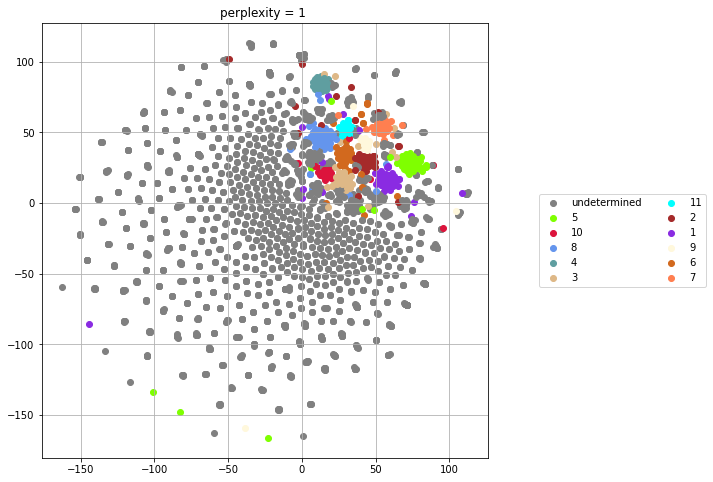

In [26]:
X_tsne_1 = TSNE(n_components=2,perplexity = 1 ).fit_transform(X)

fig, ax = plt.subplots( figsize = (8,8))
for i in range(len(X_tsne_1)):
    color = 'gray'
    lab = 'undetermined'
    
    for j in range(len(tsne_clusters.keys())):
        if raw_pd['ID'][i] in list(tsne_clusters[ list(tsne_clusters.keys())[j] ]):
            color = color_list[j]
            lab = list(tsne_clusters.keys())[j]
            
    ax.scatter(X_tsne_1[i,0], X_tsne_1[i,1], c = color,label=lab )

ax.grid()
legend_without_duplicate_labels(ax)
plt.title('perplexity = 1 ')
plt.show()

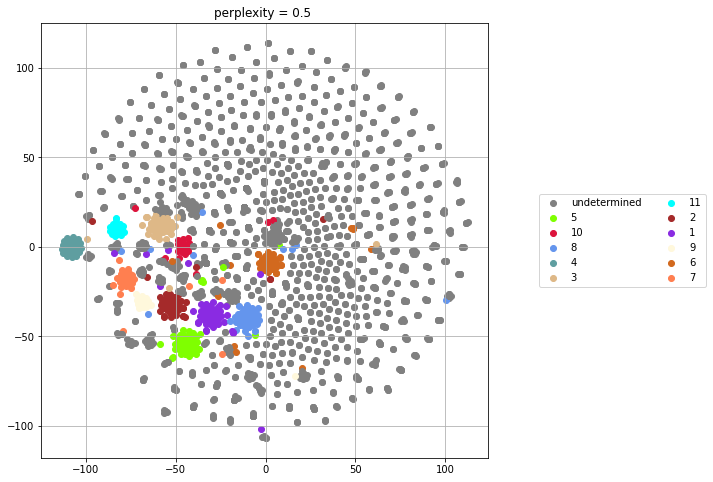

In [29]:
X_tsne_2 = TSNE(n_components=2,perplexity = 0.5 ).fit_transform(X)

fig, ax = plt.subplots( figsize = (8,8))
for i in range(len(X_tsne_2)):
    color = 'gray'
    lab = 'undetermined'
    
    for j in range(len(tsne_clusters.keys())):
        if raw_pd['ID'][i] in list(tsne_clusters[ list(tsne_clusters.keys())[j] ]):
            color = color_list[j]
            lab = list(tsne_clusters.keys())[j]
            
    ax.scatter(X_tsne_2[i,0], X_tsne_2[i,1], c = color,label=lab )

ax.grid()
legend_without_duplicate_labels(ax)
plt.title('perplexity = 0.5 ')
plt.show()

## closer look at cluster 4

In [31]:
avg_features = pd.read_csv('features_avg.csv')
cluster4 = tsne_clusters[4]
avg_features.head()

,ID,strand,TU_length,leading,lagging,terminus,Sigma70_Prib_Start,Sigma70_Prib_score,Sigma70_Prib_hmd,Sigma70_Prib_Tm,...,Roll_TSS_1,Roll_TSS_2,Roll_TSS_3,Roll_TSS_4,Roll_TSS_5,Roll_TSS_6,Roll_TSS_7,Roll_TSS_8,Roll_TSS_9,Roll_TSS_10
0,b0008,1.0,1040.0,1.0,0.0,0.0,-13.0,-4.060455,1.0,14.0,...,1.720,-3.295,-3.395,-1.970,-1.895,-1.745,-2.015,-3.515,-4.750,0.445
1,b0025,1.0,5897.0,1.0,0.0,0.0,-12.0,-3.290289,1.0,14.0,...,1.185,1.950,-2.125,1.145,1.825,1.130,1.595,0.755,0.720,-1.470
2,b0034,1.0,478.0,1.0,0.0,0.0,-13.0,-4.642584,2.0,14.0,...,0.335,-3.045,-3.050,-1.490,2.775,1.460,-2.810,-3.530,-3.375,1.030
3,b0035,-1.0,7920.0,0.0,1.0,0.0,-12.0,-5.778186,2.0,14.0,...,-3.890,2.145,2.025,2.260,1.315,-3.430,2.510,2.605,-2.630,-4.935
4,b0036,-1.0,7920.0,0.0,1.0,0.0,-12.0,-5.778186,2.0,14.0,...,-3.890,2.145,2.025,2.260,1.315,-3.430,2.510,2.605,-2.630,-4.935


Text(0.5, 1.0, 'Pribnow_sig38')

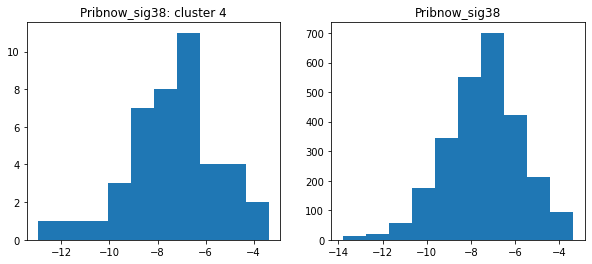

In [76]:
sig70_prib_c4 = []
for i in range(len(avg_features['ID'])):
    if list(avg_features['ID'])[i] in cluster4:
        sig70_prib_c4.append( list(avg_features['Sigma38_Prib_score'])[i] )
        
fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2, figsize=(10,4))
ax0.hist(sig70_prib_c4,bins=10)
ax0.set_title('Pribnow_sig38: cluster 4')
ax1.hist(list(avg_features['Sigma38_Prib_score']),bins=10)
ax1.set_title('Pribnow_sig38')

In [44]:
IM_genes.keys()

dict_keys(['MalT', 'GalR+GalS', 'RhaS', 'FlhDC/FliA', 'CysB-1', 'PurR-1', 'GlrR/RpoE', 'TdcA+TdcR/CadC', 'DhaR/Mlc', 'curli', 'PuuR', 'AppY-1', 'GcvA', 'BirA', 'BluR', 'PhoB-1', 'PhoP', 'YgeV', 'NagC', 'Thiamine-1', 'Fur-1', 'TyrR', 'GutM/GutR', 'RcsAB', 'NikR', 'Fnr-2', 'Nac', 'NarL', 'PhoB-2', 'EvgA', 'NarL+NarP', 'Cbl+CysB', 'PrpR', 'CysB-2', 'AtoC', 'SoxS', 'NarP', 'NtrC+RpoN', 'RpoS', 'NarL+NarP+NsrR', 'OxyR', 'GatR+Crp', 'AraC/AllR/FucR', 'FecI', 'IscR', 'LexA', 'YcjW', 'RyhB/IscR', 'Leucine', 'RbsR', 'CsqR', 'LsrR', 'AppY-2', 'Cra', 'NrdR', 'Histidine', 'Zur', 'Copper', 'XylR', 'GlpR', 'CdaR', 'RpoH', 'YiaJ', 'FlhDC', 'KdpE', 'GadEWX', 'ArgR', 'GlcC', 'IclR', 'FliA', 'Tryptophan', 'FhlA', 'GntR', 'ExuR/FucR', 'PurR-2', 'MetJ', 'Fimbriae', 'MarR', 'ArgP', 'YieP', 'Fur-2', 'CpxR', 'PaaX', 'ArcA-1', 'FadR', 'LldR', 'NanR', 'GadW'])

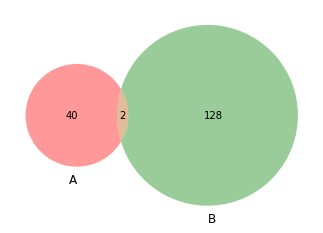

In [75]:
from matplotlib_venn import venn2
venn2([set(cluster4),set(IM_genes['RpoS'])])

## K-means clustering

In [37]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=0).fit(X)

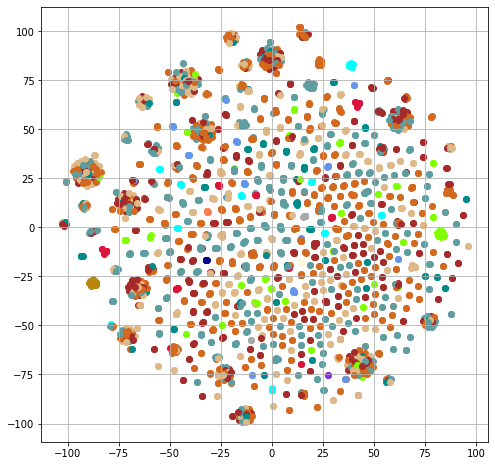

In [38]:
fig, ax = plt.subplots( figsize = (8,8))
for i in range(len(X_tsne)):
   
    color = color_list[ int(kmeans.labels_[i]) ]
    ax.scatter(X_tsne[i,0], X_tsne[i,1], c = color )

ax.grid()
plt.show()

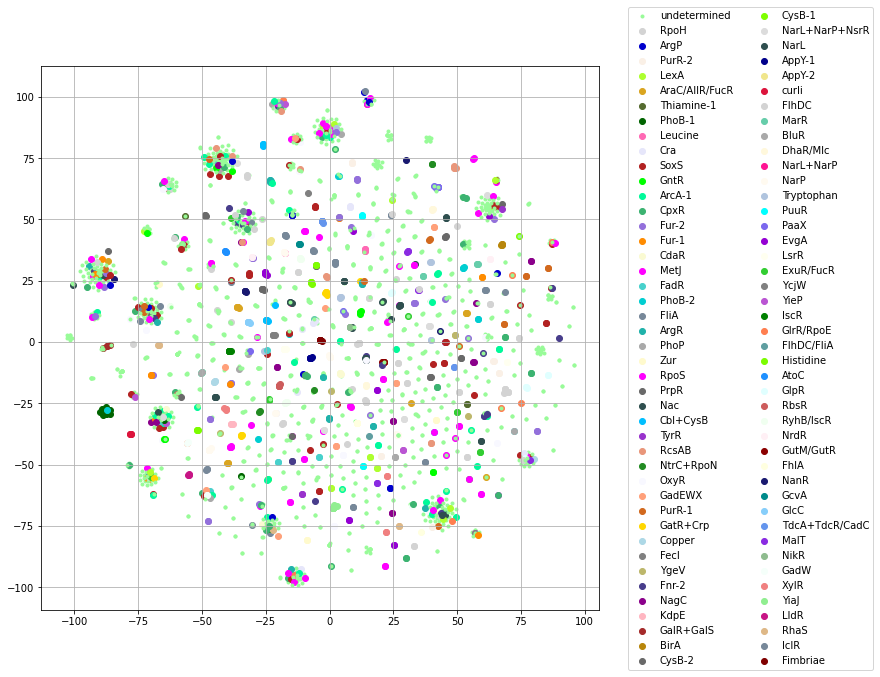

In [42]:
fig, ax = plt.subplots( figsize = (10,10))
for i in range(len(X_tsne)):
    color = color_list[99]
    lab = 'undetermined'
    mark = '.'
    
    for j in range(len(IM_genes.keys())):
        if raw_pd['ID'][i] in list(IM_genes[ list(IM_genes.keys())[j] ]):
            color = color_list[j]
            lab = list(IM_genes.keys())[j]
            mark = 'o'
            
    ax.scatter(X_tsne[i,0], X_tsne[i,1], c = color,marker = mark,label=lab )

ax.grid()
legend_without_duplicate_labels(ax)
plt.show()